# Algorithm Implementation: Oriented FAST and Rotated BRIEF (Feature macthing and outlier elimination)

In [11]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt

In [12]:
plt.rcParams['figure.figsize'] = [20,10]

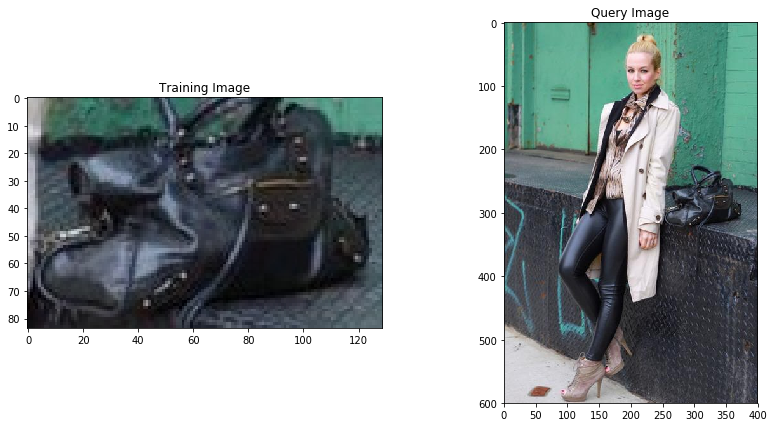

In [13]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [14.0, 7.0]

# Load the training image
image1 = cv2.imread('./MSD/sample_testset/crops/625dd192-96cc-59cd-83d0-ad5fa710b4bb.jpg')

# Load the query image
image2 = cv2.imread('./MSD/sample_testset/images/00c58d88-53e0-5314-947d-4763004df6df.jpg')

# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert the query image to RGB
query_image = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Display the images
plt.subplot(121)
plt.imshow(training_image)
plt.title('Training Image')
plt.subplot(122)
plt.imshow(query_image)
plt.title('Query Image')
plt.show()

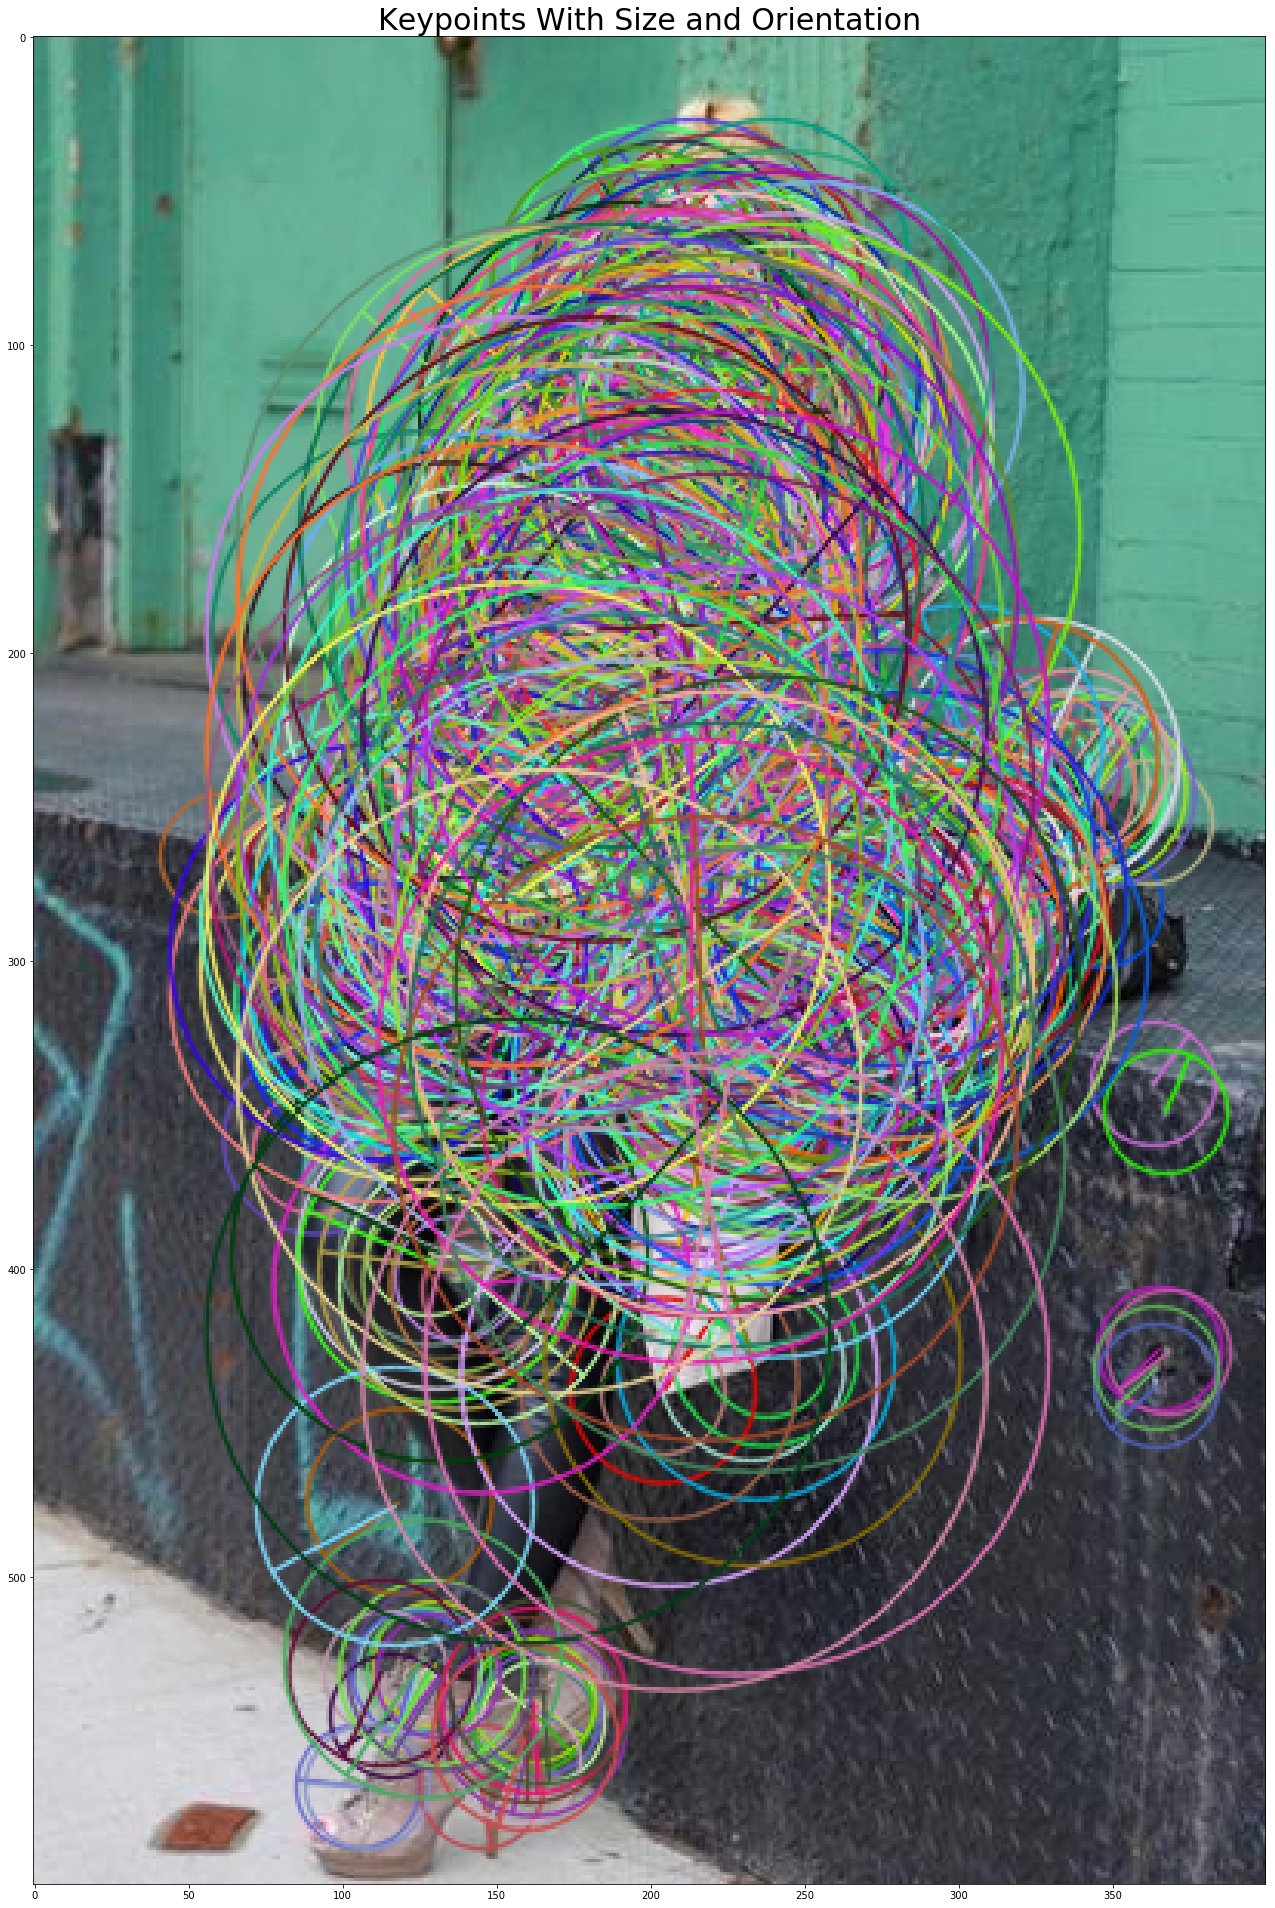


Number of keypoints Detected:  873


In [24]:
import copy
# Set the default figure size
plt.rcParams['figure.figsize'] = [34.0, 34.0]

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_BGR2GRAY)

# Convert the query image to gray scale
query_gray = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)

# sift = cv2.xfeatures2d.SIFT_create()
# Set the parameters of the ORB algorithm by specifying the maximum number of keypoints to locate and
# the pyramid decimation ratio

orb = cv2.ORB_create(nfeatures=1000, scaleFactor=1.5, edgeThreshold = 31, WTA_K = 4, patchSize = 40)

# Find the keypoints in the gray scale training and query images and compute their ORB descriptor.
# The None parameter is needed to indicate that we are not using a mask in either case.  
keypoints_train, descriptors_train = orb.detectAndCompute(training_gray, None)
keypoints_query, descriptors_query = orb.detectAndCompute(query_gray, None)

# Create copies of the query images to draw our keypoints on
query_img_keyp = copy.copy(query_image)

# Draw the keypoints with size and orientation on the copy of the query image
cv2.drawKeypoints(query_image, keypoints_query, query_img_keyp, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the query image with the keypoints with size and orientation
plt.title('Keypoints With Size and Orientation', fontsize = 30)
plt.imshow(query_img_keyp)
plt.show()

# Print the number of keypoints detected
print("\nNumber of keypoints Detected: ", len(keypoints_query))

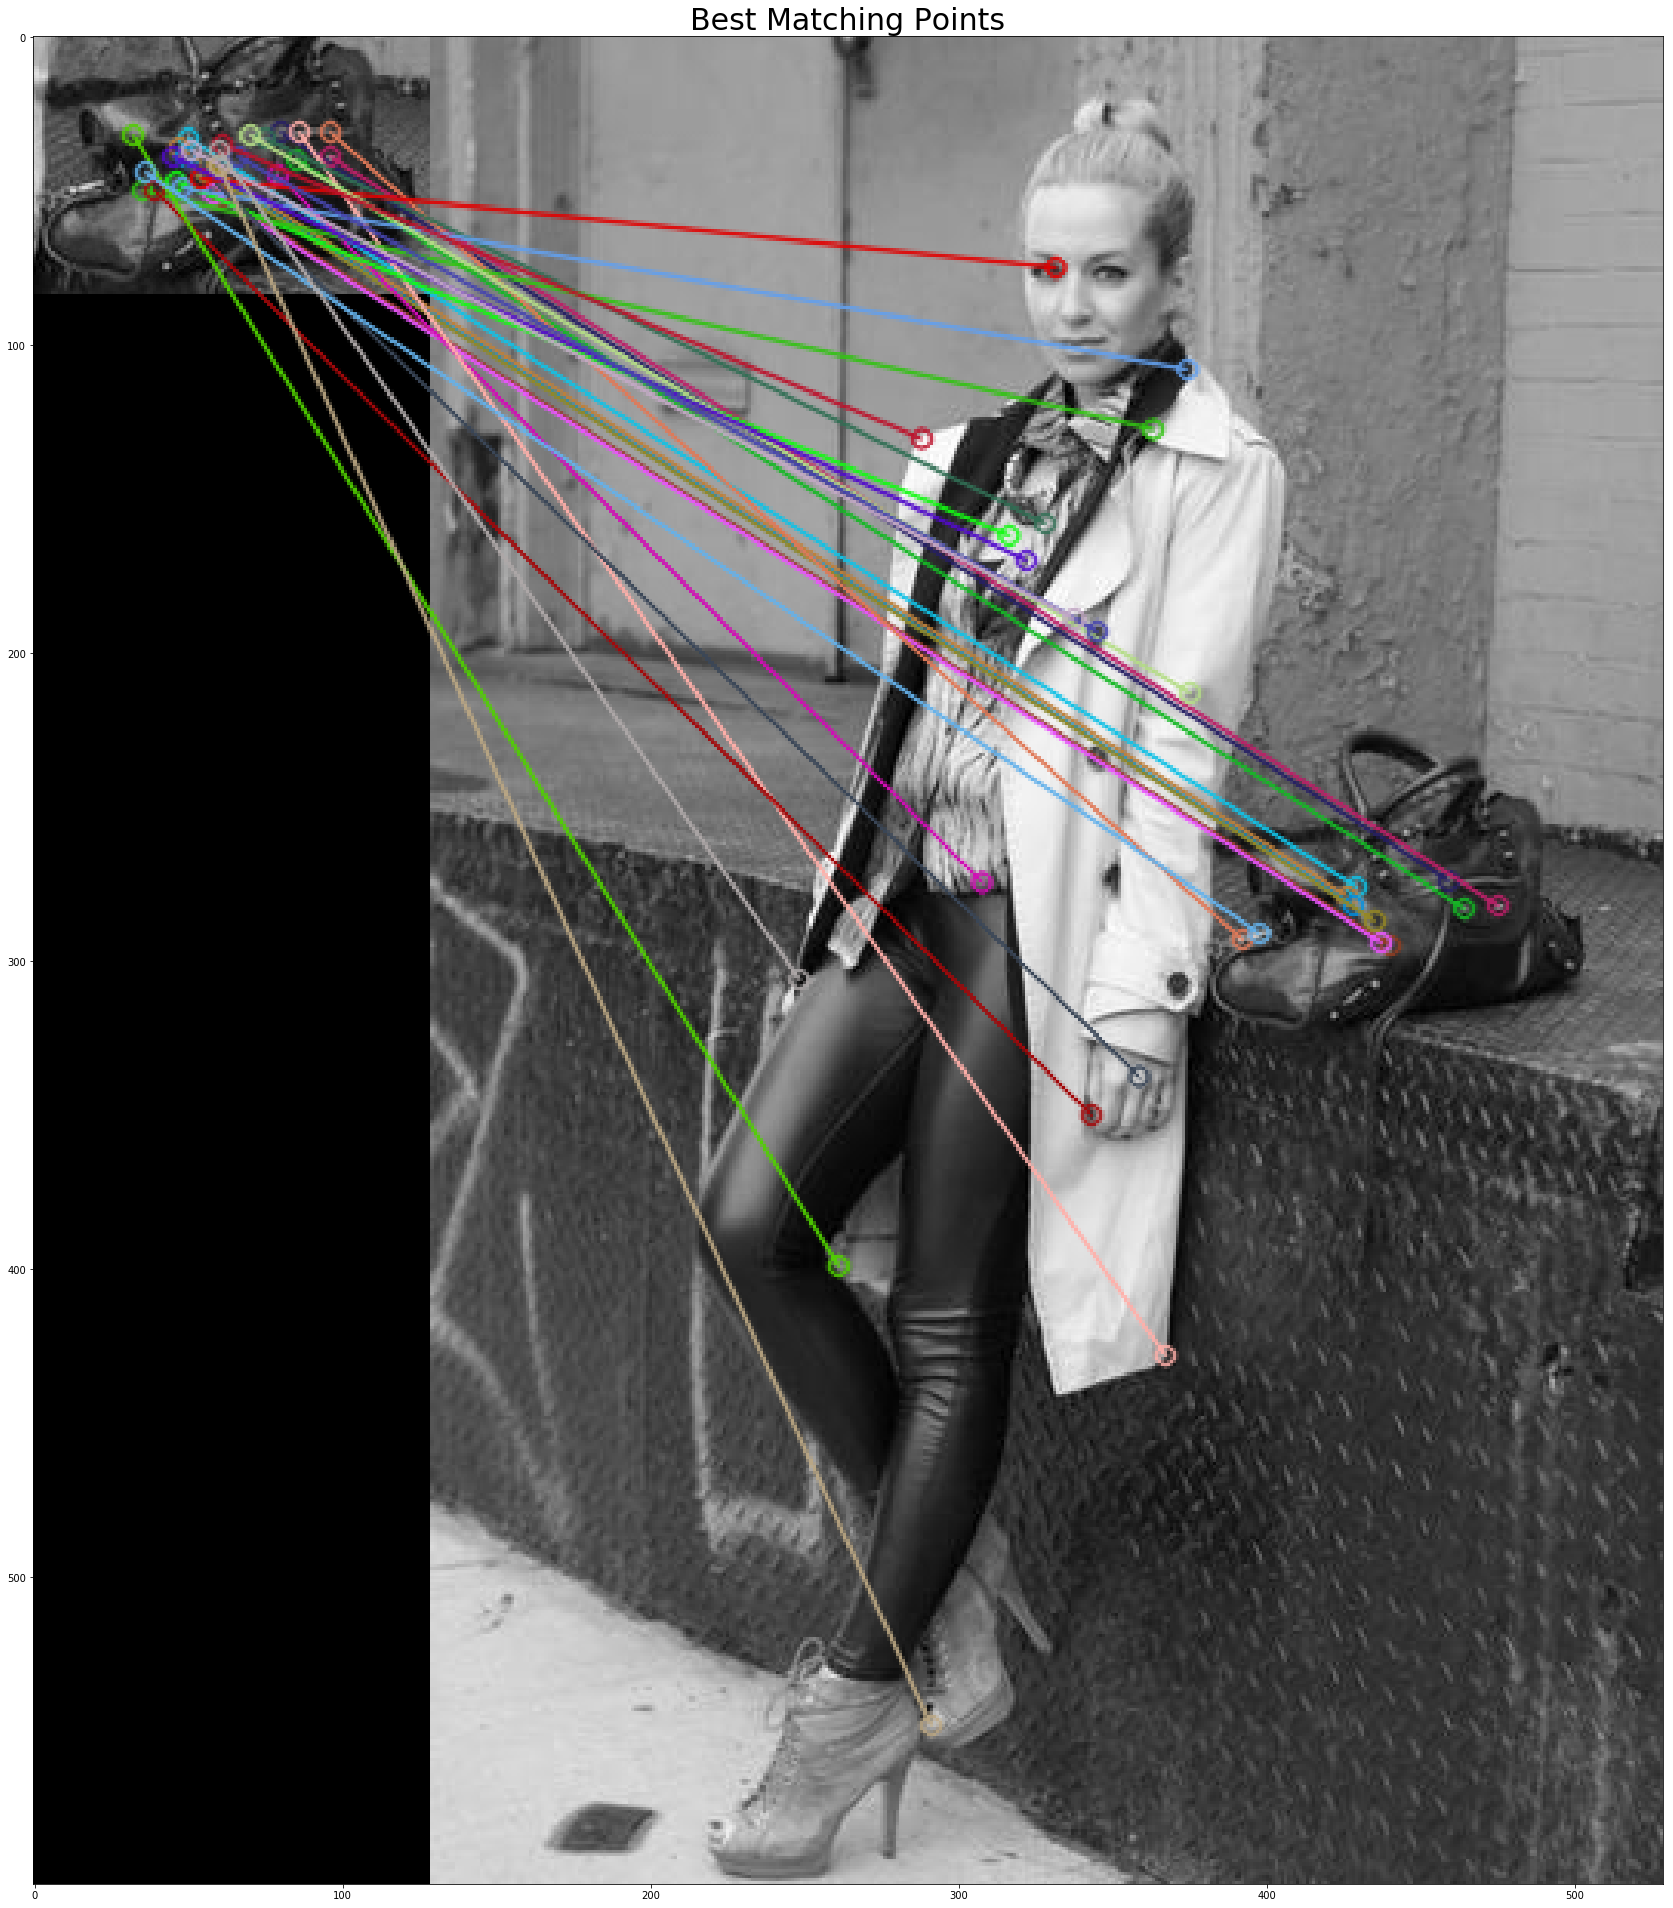

Number of Keypoints Detected In The Training Image:  37
Number of Keypoints Detected In The Query Image:  873

Number of Matching Keypoints Between The Training and Query Images:  28


In [25]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [34.0, 34.0]

# Create a Brute Force Matcher object. We set crossCheck to True so that the BFMatcher will only return consistent
# pairs. Such technique usually produces best results with minimal number of outliers when there are enough matches.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)


matches = bf.match(descriptors_train, descriptors_query)

    # The matches with shorter distance are required. So, the matches are sort according to distance
matches = sorted(matches, key = lambda x : x.distance)

# Connect the keypoints in the training image with their best matching keypoints in the query image.
# The best matches correspond to the first elements in the sorted matches list, since they are the ones
# with the shorter distance. We draw the first 85 mathces and use flags = 2 to plot the matching keypoints
# without size or orientation.
result = cv2.drawMatches(training_gray, keypoints_train, query_gray, keypoints_query, matches[:85], query_gray, flags = 2)

# we display the image
plt.title('Best Matching Points', fontsize = 30)
plt.imshow(result)
plt.show()

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(keypoints_train))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(keypoints_query))

# Print total number of matching Keypoints between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

In [26]:
# Initialize lists
list_kp1 = []
list_kp2 = []

# For each match...
c=0
for mat in matches:

    # Get the matching keypoints for each of the images
    img1_idx = mat.queryIdx
    img2_idx = mat.trainIdx

    # x - columns
    # y - rows
    # Get the coordinates
    (x1,y1) = keypoints_query[img2_idx].pt
    (x2,y2) = keypoints_train[img1_idx].pt

    # Append to each list
    list_kp1.append((x1, y1))
    list_kp2.append((x2, y2))

In [27]:
import numpy as np 

# match count threshold
MIN_MATCH_COUNT = 10
if len(matches)>MIN_MATCH_COUNT:
    
    # Converting keypoints to coordinates
    src_pts = np.float32([ keypoints_train[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints_query[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    x_max, y_max = np.max(np.max(dst_pts, axis=1), axis=0)
    x_min, y_min = np.min(np.min(dst_pts, axis=1), axis=0)
    
    # Homography is aaplied in case of 3d projection of crops
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    print(x_max,x_min, y_max, y_min)

    h,w = training_gray.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    
    # Doing a perspective transform to get four corner coordinates
    dst = cv2.perspectiveTransform(pts,M)
    
    print(dst)
    print(np.int32(dst))
    query_gray = cv2.polylines(query_gray,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    
    # Calculating contour area (just a brute-force method to eliminate false-positives)
    area = cv2.contourArea(dst)
    original_area = h*w
    if abs(area-original_area)>500:
        print("Not enough matches are found - %d/%d" % (len(matches),MIN_MATCH_COUNT))
        matchesMask = None
    print(area, (h*w))

else:
    print("Not enough matches are found - %d/%d" % (len(matches),MIN_MATCH_COUNT))
    matchesMask = None

346.0 119.25 548.0 75.0
[[[250. 243.]]

 [[250. 326.]]

 [[378. 326.]]

 [[378. 243.]]]
[[[250 243]]

 [[250 326]]

 [[378 326]]

 [[378 243]]]
10624.0 10836


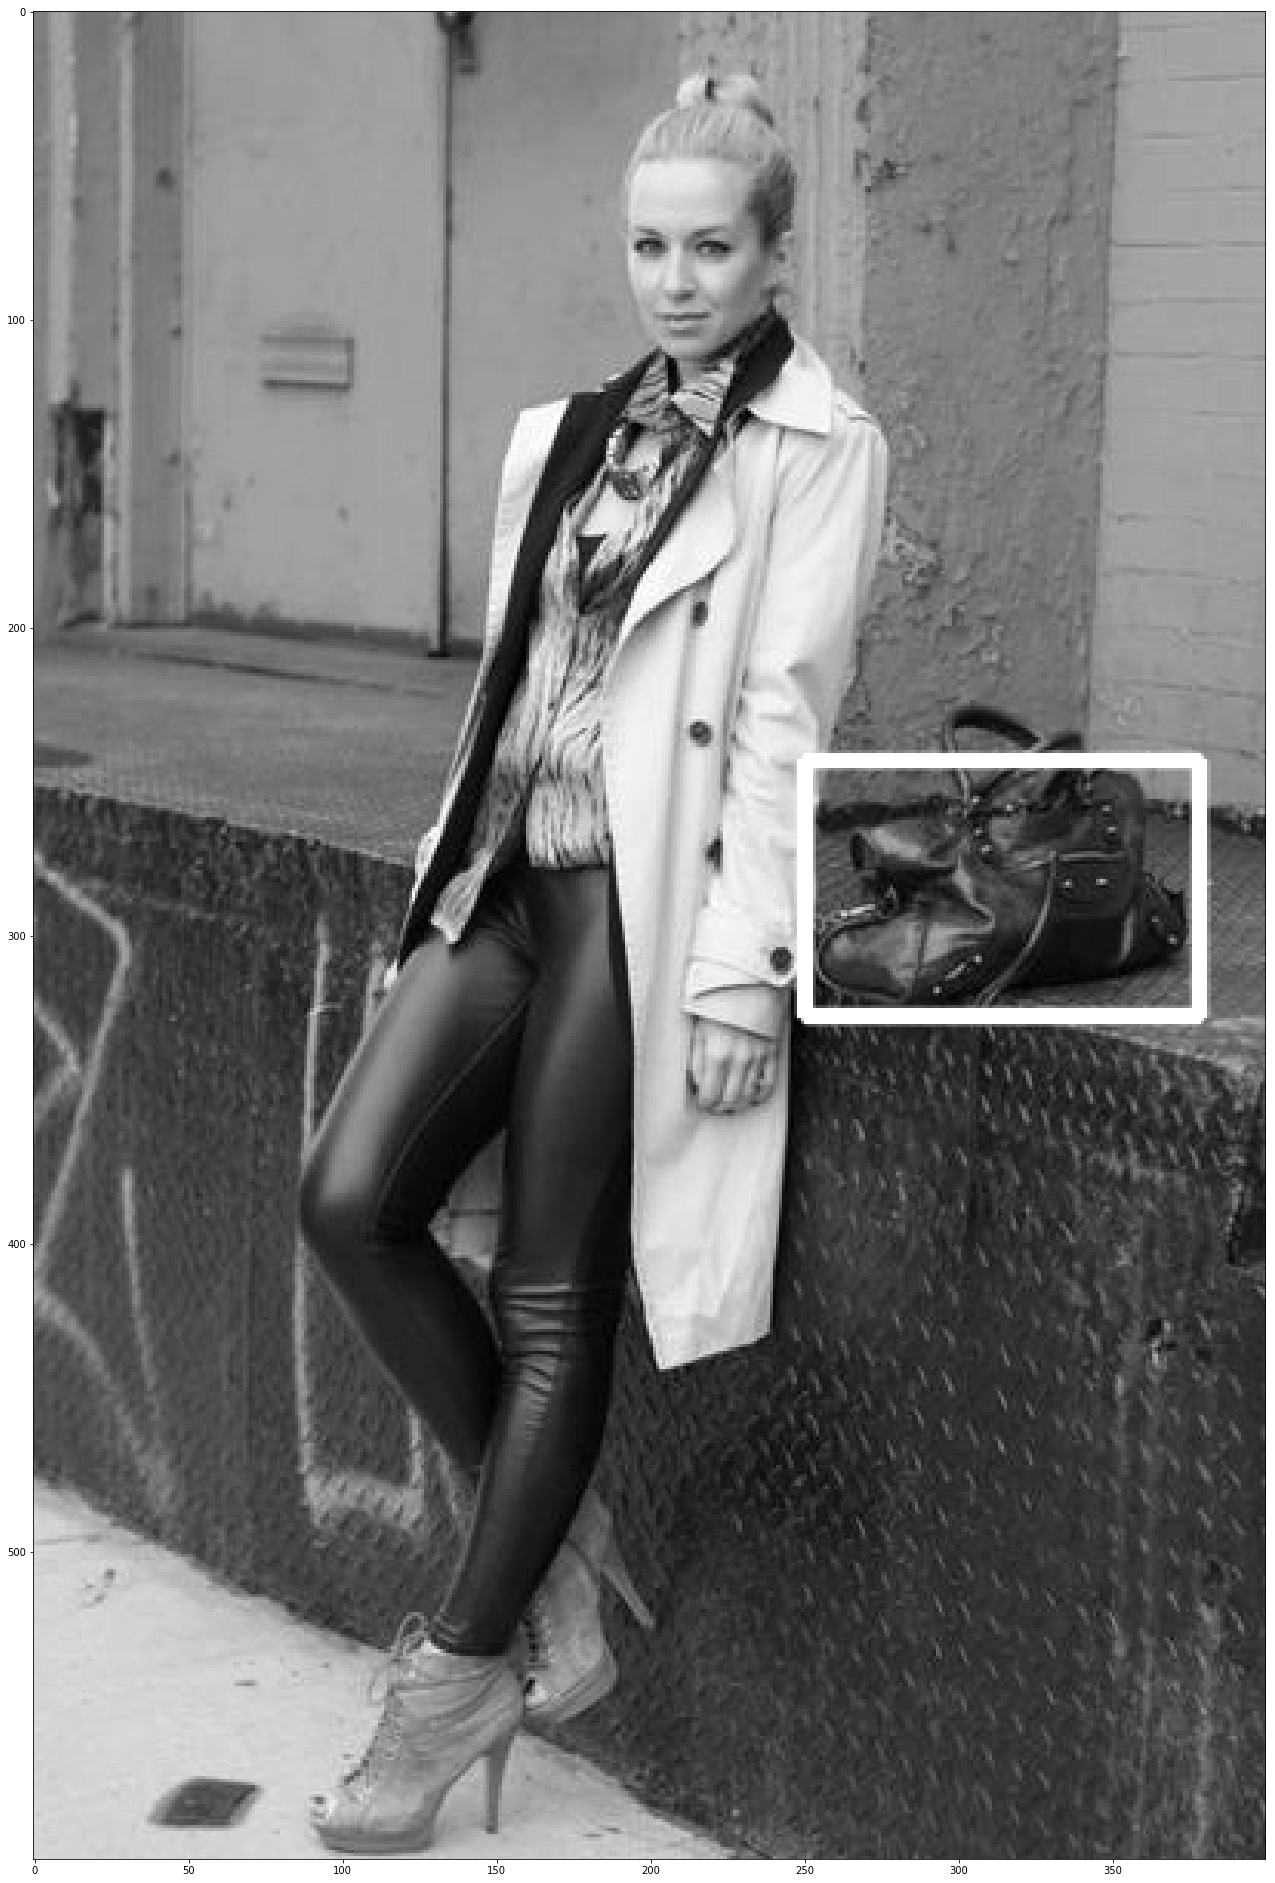

In [28]:
plt.imshow(query_gray, cmap='gray')
plt.show()